In [2]:
import pandas as pd

raw_df = pd.read_csv("/Users/elifakdeniz/Desktop/DTA/2025/ComputitonalLit.Studies/Project/shakespeare_plays.csv")

raw_df.info(), raw_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108093 entries, 0 to 108092
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  108093 non-null  int64 
 1   play_name   108093 non-null  object
 2   genre       108093 non-null  object
 3   character   108093 non-null  object
 4   act         108093 non-null  int64 
 5   scene       108093 non-null  int64 
 6   sentence    108093 non-null  int64 
 7   text        108093 non-null  object
 8   sex         108093 non-null  object
dtypes: int64(4), object(5)
memory usage: 7.4+ MB


(None,
    Unnamed: 0                  play_name   genre character  act  scene  \
 0           0  All's Well That Ends Well  Comedy  Countess    1      1   
 1           1  All's Well That Ends Well  Comedy   Bertram    1      1   
 2           2  All's Well That Ends Well  Comedy   Bertram    1      1   
 3           3  All's Well That Ends Well  Comedy   Bertram    1      1   
 4           4  All's Well That Ends Well  Comedy     Lafeu    1      1   
 
    sentence                                               text     sex  
 0         1  In delivering my son from me, I bury a second ...  female  
 1         2  And I in going, madam, weep o'er my father's d...    male  
 2         3  anew: but I must attend his majesty's command, to    male  
 3         4     whom I am now in ward, evermore in subjection.    male  
 4         5  You shall find of the king a husband, madam; you,    male  )

Build Character Networks
We'll do this per play and per act, using:


Nodes → Characters
Edges → Co-occurrence in the same scene
Scope → Top 3 most talkative characters per act

In [9]:
import os
import networkx as nx

def build_full_play_networks(df, output_dir="full_play_networks"):
    os.makedirs(output_dir, exist_ok=True)
    
    play_graphs = {}
    
    for play, play_df in df.groupby("play_name"):
        G = nx.Graph()

        characters = play_df['character'].unique()
        G.add_nodes_from(characters)

        for _, scene_df in play_df.groupby(['act', 'scene']):
            scene_chars = scene_df['character'].unique()
            for i in range(len(scene_chars)):
                for j in range(i + 1, len(scene_chars)):
                    c1, c2 = scene_chars[i], scene_chars[j]
                    if G.has_edge(c1, c2):
                        G[c1][c2]['weight'] += 1
                    else:
                        G.add_edge(c1, c2, weight=1)

        safe_play = play.replace(" ", "_").replace("'", "")
        filepath = os.path.join(output_dir, f"{safe_play}.gexf")
        nx.write_gexf(G, filepath)
        play_graphs[play] = G
        print(f"Saved: {filepath}")

    return play_graphs

raw_df = pd.read_csv("/Users/elifakdeniz/Desktop/DTA/2025/ComputitonalLit.Studies/Project/shakespeare_plays.csv")
full_play_graphs = build_full_play_networks(raw_df)


Saved: full_play_networks/A_Midsummer_Nights_Dream.gexf
Saved: full_play_networks/Alls_Well_That_Ends_Well.gexf
Saved: full_play_networks/Antony_and_Cleopatra.gexf
Saved: full_play_networks/As_You_Like_It.gexf
Saved: full_play_networks/Coriolanus.gexf
Saved: full_play_networks/Cymbeline.gexf
Saved: full_play_networks/Hamlet.gexf
Saved: full_play_networks/Henry_IV,_part_1.gexf
Saved: full_play_networks/Henry_IV,_part_2.gexf
Saved: full_play_networks/Henry_V.gexf
Saved: full_play_networks/Henry_VI,_part_1.gexf
Saved: full_play_networks/Henry_VI,_part_2.gexf
Saved: full_play_networks/Henry_VI,_part_3.gexf
Saved: full_play_networks/Henry_VIII.gexf
Saved: full_play_networks/Julius_Caesar.gexf
Saved: full_play_networks/King_John.gexf
Saved: full_play_networks/King_Lear.gexf
Saved: full_play_networks/Loves_Labours_Lost.gexf
Saved: full_play_networks/Macbeth.gexf
Saved: full_play_networks/Measure_for_Measure.gexf
Saved: full_play_networks/Much_Ado_About_Nothing.gexf
Saved: full_play_networks/O

In [17]:
gexf_folder = "/Users/elifakdeniz/Desktop/DTA/2025/ComputitonalLit.Studies/Project/full play network"

raw_df = pd.read_csv("/Users/elifakdeniz/Desktop/DTA/2025/ComputitonalLit.Studies/Project/shakespeare_plays.csv")
genre_map = raw_df[['play_name', 'genre']].drop_duplicates().set_index('play_name')['genre'].to_dict()

character_data = []

for filename in os.listdir(gexf_folder):
    if filename.endswith(".gexf"):
        play_name = filename.replace(".gexf", "").replace("_", " ")
        G = nx.read_gexf(os.path.join(gexf_folder, filename))

        degree = dict(G.degree())
        degree_centrality = nx.degree_centrality(G)
        betweenness_centrality = nx.betweenness_centrality(G)

        for character in G.nodes():
            character_data.append({
                "play_name": play_name,
                "character": character,
                "degree": degree.get(character, 0),
                "degree_centrality": degree_centrality.get(character, 0),
                "betweenness_centrality": betweenness_centrality.get(character, 0),
                "genre": genre_map.get(play_name, "Unknown")
            })

df_characters = pd.DataFrame(character_data)
df_characters.to_csv("character_level_features.csv", index=False)
df_characters.head(10)


,play_name,character,degree,degree_centrality,betweenness_centrality,genre
0,Troilus and Cressida,Troilus,22,0.814815,0.134113,Comedy
1,Troilus and Cressida,Pandarus,15,0.555556,0.087946,Comedy
2,Troilus and Cressida,Aeneas,17,0.629630,0.021434,Comedy
3,Troilus and Cressida,Cressida,19,0.703704,0.083353,Comedy
4,Troilus and Cressida,Alexander,3,0.111111,0.000000,Comedy
5,Troilus and Cressida,Boy,4,0.148148,0.001266,Comedy
6,Troilus and Cressida,Agamemnon,15,0.555556,0.005181,Comedy
7,Troilus and Cressida,Nestor,15,0.555556,0.005181,Comedy
8,Troilus and Cressida,Ulysses,15,0.555556,0.005181,Comedy
9,Troilus and Cressida,Menelaus,14,0.518519,0.000734,Comedy


1. Compare Genres Structurally


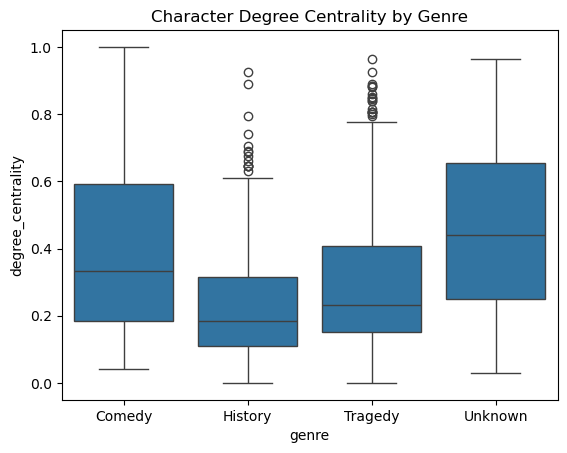

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df_characters, x="genre", y="degree_centrality")
plt.title("Character Degree Centrality by Genre")
plt.show()


2. Rank Characters
See who’s structurally dominant:

In [22]:
df_characters.sort_values(by="betweenness_centrality", ascending=False).head(10)

,play_name,character,degree,degree_centrality,betweenness_centrality,genre
185,"Pericles, Prince of Tyre",Pericles,32,0.711111,0.462043,Comedy
287,Cymbeline,Posthumus Leonatus,28,0.717949,0.330980,Comedy
920,Coriolanus,Coriolanus,49,0.816667,0.324980,Tragedy
516,Henry V,Exeter,29,0.644444,0.317705,History
805,"Henry VI, part 1",Talbot,35,0.686275,0.306865,History
515,Henry V,King Henry V,31,0.688889,0.296839,History
80,"Henry IV, part 2",Falstaff,28,0.608696,0.283975,History
840,Richard II,King Richard Ii,27,0.794118,0.268446,History
110,"Henry IV, part 2",Lancaster,18,0.391304,0.264079,History
502,Two Gentlemen of Verona,Silvia,13,0.812500,0.257847,Comedy


In [46]:
import pandas as pd


output_path = "/Users/elifakdeniz/Desktop/DTA/2025/ComputitonalLit.Studies/Project/character_level_features.xlsx"
df_characters.to_excel(output_path, index=False)

print(f"Saved successfully to {output_path}")


Saved successfully to /Users/elifakdeniz/Desktop/DTA/2025/ComputitonalLit.Studies/Project/character_level_features.xlsx


In [24]:
df_characters.groupby("genre")[["degree", "degree_centrality", "betweenness_centrality"]].mean()

,degree,degree_centrality,betweenness_centrality
genre,,,
Comedy,10.191358,0.396589,0.025315
History,11.006397,0.233628,0.022487
Tragedy,12.280193,0.304755,0.017588
Unknown,12.472727,0.476577,0.022219


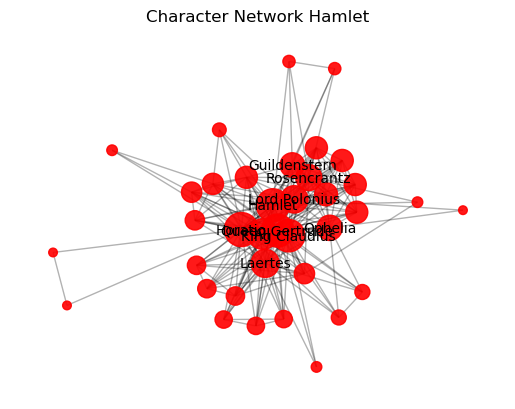

In [32]:
G = nx.read_gexf("/Users/elifakdeniz/Desktop/DTA/2025/ComputitonalLit.Studies/Project/full play network/Hamlet.gexf")

centrality = nx.degree_centrality(G)

pos = nx.spring_layout(G, seed=42)

node_sizes = [700 * centrality[n] for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='red', alpha=0.9)

nx.draw_networkx_edges(G, pos, alpha=0.3)

important_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
labels = {k: k for k, v in important_nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color="black")

plt.title("Character Network Hamlet")
plt.axis('off')
plt.show()


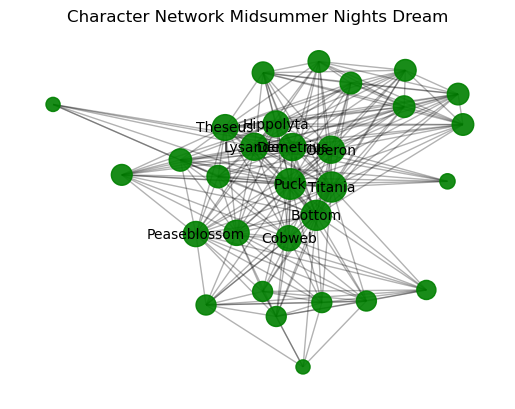

In [35]:
G = nx.read_gexf("/Users/elifakdeniz/Desktop/DTA/2025/ComputitonalLit.Studies/Project/full play network/A_Midsummer_Nights_Dream.gexf")

centrality = nx.degree_centrality(G)

pos = nx.spring_layout(G, seed=42)

node_sizes = [500 * centrality[n] for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='green', alpha=0.9)

nx.draw_networkx_edges(G, pos, alpha=0.3)

important_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
labels = {k: k for k, v in important_nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color="black")

plt.title("Character Network Midsummer Nights Dream")
plt.axis('off')
plt.show()

In [36]:
!pip install plotly

With interactive way to do:

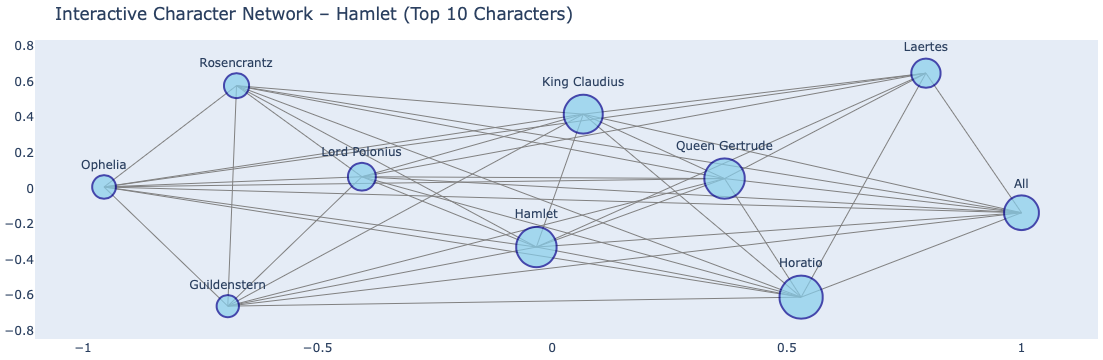

In [38]:
import networkx as nx
import plotly.graph_objects as go

G = nx.read_gexf("/Users/elifakdeniz/Desktop/DTA/2025/ComputitonalLit.Studies/Project/full play network/Hamlet.gexf")

centrality = nx.degree_centrality(G)
top_chars = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_nodes = [name for name, score in top_chars]

G_sub = G.subgraph(top_nodes)
pos = nx.spring_layout(G_sub, seed=42)

x_nodes = [pos[n][0] for n in G_sub.nodes()]
y_nodes = [pos[n][1] for n in G_sub.nodes()]
node_text = list(G_sub.nodes())

node_sizes = [centrality[n]*50 for n in G_sub.nodes()]

edge_x = []
edge_y = []
for edge in G_sub.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=edge_x, y=edge_y,
    mode='lines',
    line=dict(width=1, color='gray'),
    hoverinfo='none'
))

fig.add_trace(go.Scatter(
    x=x_nodes, y=y_nodes,
    mode='markers+text',
    text=node_text,
    textposition="top center",
    marker=dict(
        size=node_sizes,
        color='skyblue',
        line=dict(width=2, color='darkblue')
    ),
    hoverinfo='text'
))

fig.update_layout(
    title="Interactive Character Network – Hamlet (Top 10 Characters)",
    showlegend=False,
    hovermode='closest',
    margin=dict(b=20,l=5,r=5,t=40),
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False)
)

fig.show()


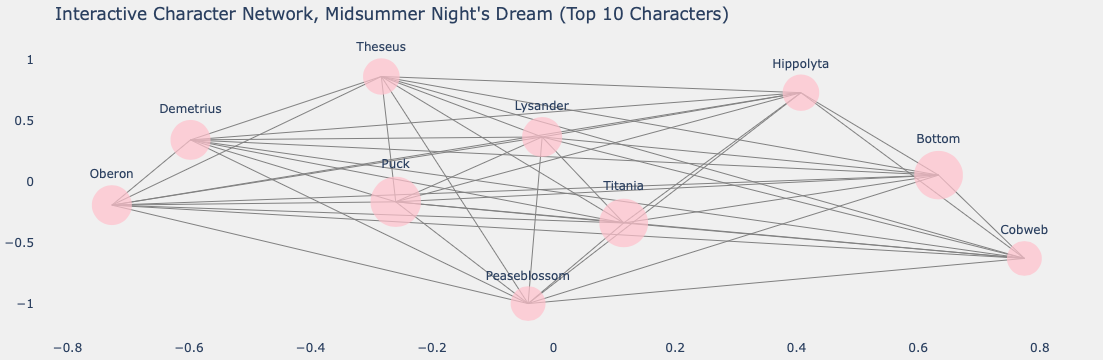

In [53]:
G = nx.read_gexf("/Users/elifakdeniz/Desktop/DTA/2025/ComputitonalLit.Studies/Project/1-Network analysis/full play network/A_Midsummer_Nights_Dream.gexf")

centrality = nx.degree_centrality(G)
top_chars = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_nodes = [name for name, score in top_chars]

G_sub = G.subgraph(top_nodes)
pos = nx.spring_layout(G_sub, seed=42)

x_nodes = [pos[n][0] for n in G_sub.nodes()]
y_nodes = [pos[n][1] for n in G_sub.nodes()]
node_text = list(G_sub.nodes())

node_sizes = [centrality[n]*50 for n in G_sub.nodes()]

edge_x = []
edge_y = []
for edge in G_sub.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=edge_x, y=edge_y,
    mode='lines',
    line=dict(width=1, color='gray'),
    hoverinfo='none'
))

fig.add_trace(go.Scatter(
    x=x_nodes, y=y_nodes,
    mode='markers+text',
    text=node_text,
    textposition="top center",
    marker=dict(
        size=node_sizes,
        color='pink',
        line=dict(width=2, color='pink')
    ),
    hoverinfo='text'
))

fig.update_layout(
    title="Interactive Character Network, Midsummer Night's Dream (Top 10 Characters)",
    showlegend=False,
    hovermode='closest',
    margin=dict(b=20, l=5, r=5, t=40),
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),
    plot_bgcolor='#f0f0f0',
    paper_bgcolor='#f0f0f0'
)

fig.show()

These patterns support the hypothesis that genre manifests structurally: tragedies tend to center around singular, fated characters (e.g., Hamlet), while comedies involve relational entanglements across a wider cast.

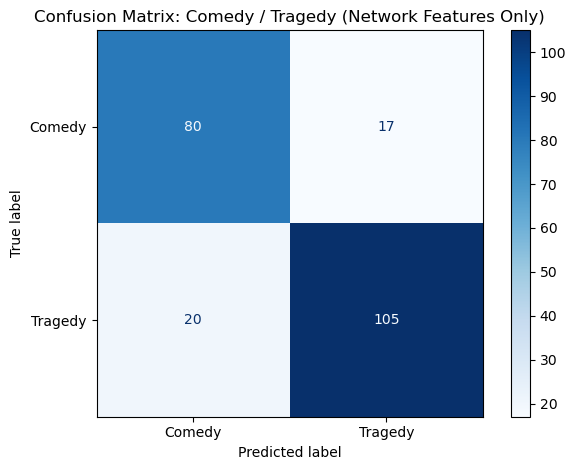

'              precision    recall  f1-score   support\n\n      Comedy       0.80      0.82      0.81        97\n     Tragedy       0.86      0.84      0.85       125\n\n    accuracy                           0.83       222\n   macro avg       0.83      0.83      0.83       222\nweighted avg       0.83      0.83      0.83       222\n'

In [61]:


df_binary = df[df['genre'].isin(['Comedy', 'Tragedy'])].copy()
df_binary['genre_encoded'] = label_encoder.fit_transform(df_binary['genre'])

X_bin = df_binary[["degree", "degree_centrality", "betweenness_centrality"]]
y_bin = df_binary["genre_encoded"]

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_bin, y_bin, test_size=0.3, random_state=42, stratify=y_bin
)

clf_bin = RandomForestClassifier(n_estimators=100, random_state=42)
clf_bin.fit(X_train_bin, y_train_bin)

y_pred_bin = clf_bin.predict(X_test_bin)
report_bin = classification_report(
    y_test_bin, y_pred_bin, target_names=label_encoder.classes_[:2]
)
conf_matrix_bin = confusion_matrix(y_test_bin, y_pred_bin)

disp = ConfusionMatrixDisplay(conf_matrix_bin, display_labels=label_encoder.classes_[:2])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Comedy / Tragedy (Network Features Only)")
plt.tight_layout()
plt.show()

report_bin


The model's overall accuracy increased to 83% when the classification task was focused on Comedy and Tragedy, suggesting a more obvious difference in the character network patterns of these two genres. 82% of the time, comedy characters were accurately identified, and 84% of the time, sad characters were correctly anticipated. The confusion matrix's low level of genre confusion highlights the predictive strength of degree, betweenness centrality, and degree centrality as structural markers unique to a given genre.

In [67]:

grouped = raw_df.groupby(['play_name', 'act', 'scene'])['character'].unique().reset_index()

pair_counts = Counter()
for _, row in grouped.iterrows():
    characters = row['character']
    for pair in combinations(sorted(set(characters)), 2):
        key = (row['play_name'], pair[0], pair[1])
        pair_counts[key] += 1

edges = pd.DataFrame([
    {'play_name': play, 'source': char1, 'target': char2, 'weight': weight}
    for (play, char1, char2), weight in pair_counts.items()
])

edges.head() 

,play_name,source,target,weight
0,A Midsummer Night's Dream,Demetrius,Egeus,2
1,A Midsummer Night's Dream,Demetrius,Helena,5
2,A Midsummer Night's Dream,Demetrius,Hermia,4
3,A Midsummer Night's Dream,Demetrius,Hippolyta,3
4,A Midsummer Night's Dream,Demetrius,Lysander,5


In [66]:
edges.to_csv("shakespeare_edge_list.csv", index=False)
